# Classification de signaux sismiques grâce à la selection de features et l'apprentissage de dictionnaire

L'objectif de ce notebook est de faire de la classification sur des signaux sismiques.
Un signal sismique comporte (vulgairement) deux types d'ondes :
* Une onde P de compression, qui marque le début du seisme, peu puissante.
* Une onde S de cisaillement, beaucoup plus puissante et dangereuse, qui survient après l'onde P.
* On peut également considérer les résidus laissés après le passage de l'onde S.

Pouvoir prédire un seisme, et précisément à quelle type d'onde on a à faire, peut être capital pour prévenir des désastres.
Notre but est simple : en utilisant le dataset [STEAD](https://www.kaggle.com/datasets/isevilla/stanford-earthquake-dataset-stead), on veut segmenter notre signal sismique en quatre classes distinctes:
* Onde P.
* Onde S.
* Classe pré sismique (On peut considérer qu'il s'agit d'une absence de signal).
* Classe post sismique (Située après le label coda end dans le dataset).



## Chargement des fichiers

In [1]:
# pour optimiser la vitesse de tsfresh
import os
os.environ['OMP_NUM_THREADS'] = "1"
os.environ['MKL_NUM_THREADS'] = "1"
os.environ['OPENBLAS_NUM_THREADS'] = "1"

In [1]:
! pip install tsfresh

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


In [654]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction.settings import MinimalFCParameters, EfficientFCParameters
from scipy.stats import entropy, kurtosis
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import select_features
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict


In [4]:
root = "/mnt/c/Users/Danym/Downloads/merged"
file_name = os.path.join(root, "merge.hdf5")
csv_file = os.path.join(root, "merge.csv")

In [166]:
class Earthquake:
    def __init__(self, trace_name, magnitude, distance, data, attrs, is_earthquake):
        """
        Initialise un objet représentant un séisme.

        :param trace_name: Nom de la trace
        :param magnitude: Magnitude du séisme
        :param distance: Distance à la source (en km)
        :param data: Forme d'onde (tableau numpy)
        :param attrs: Attributs HDF5 (dict)
        """
        self.trace_name = trace_name
        self.magnitude = magnitude
        self.distance = distance
        self.data = data  # Formes d'onde : 3 canaux (E, N, Z)
        self.attrs = attrs  # Attributs comme p_arrival, s_arrival, coda_end
        self.is_earthquake = is_earthquake
        self.window_data = None
        self.feature_vector = None

    def plot_waveforms(self):
        """
        Trace les formes d'onde des trois canaux : E, N, Z, avec l'axe des x (indices ou temps).
        """
        fig = plt.figure(figsize=(15, 15))
        x = np.arange(self.data.shape[0]) 

        for i, channel in enumerate(['E', 'N', 'Z']):
            ax = fig.add_subplot(3, 1, i + 1)
            plt.plot(x, self.data[:, i], 'k') 
            plt.ylabel(f'Amplitude ({channel})', fontsize=12)
            plt.xlabel("Sample index", fontsize=12)
            plt.rcParams["figure.figsize"] = (8, 5)
            ymin, ymax = ax.get_ylim()

            if self.is_earthquake == True:
                # Ajout des lignes des attributs
                if 'p_arrival_sample' in self.attrs:
                    plt.vlines(self.attrs['p_arrival_sample'], ymin, ymax, color='b', linewidth=2, label='P-arrival')
                if 's_arrival_sample' in self.attrs:
                    plt.vlines(self.attrs['s_arrival_sample'], ymin, ymax, color='r', linewidth=2, label='S-arrival')
                if 'coda_end_sample' in self.attrs:
                    plt.vlines(self.attrs['coda_end_sample'], ymin, ymax, color='aqua', linewidth=2, label='Coda End')

            plt.legend(loc='upper right', fontsize=10)

        plt.tight_layout()
        sns.despine()
        plt.show()


    def __str__(self):
        """
        Représentation textuelle de l'objet.
        """
        status = "Earthquake" if self.is_earthquake else "Non-earthquake"
        return f"{status} {self.trace_name} - Magnitude: {self.magnitude}, Distance: {self.distance} km"

    def __repr__(self):
        """
        Représentation officielle de l'objet pour les développeurs (utilisé par repr()).
        """
        return (f"Earthquake(trace_name='{self.trace_name}', "
                f"magnitude={self.magnitude}, distance={self.distance}, is_earthquake={self.is_earthquake})")


## Sélection des données séismes

In [167]:
proportion = 0.001
df = pd.read_csv(csv_file)
print(f'Total events in CSV file: {len(df)}')

# Filtrage du dataframe pour les séismes
df['is_earthquake'] = (df['trace_category'] == 'earthquake_local')  # True pour séismes, False sinon

#Ici je sélectionne les séismes qui ont une distance inférieure à 10 km et une magnitude supérieure à 3
df = df[df['is_earthquake']]
print(f'Total events selected: {len(df)}')
print(f"Selection of {int(len(df) * proportion)} events")
# Création d'une liste de noms de traces pour les données sélectionnées
ev_list = df['trace_name'].to_list()
np.random.shuffle(ev_list)
# Liste pour stocker les objets Earthquake
earthquakes = []

end = int(proportion * len(ev_list))
dtfl = h5py.File(file_name, 'r')
for c, evi in tqdm(enumerate(ev_list[0:end])):
    dataset = dtfl.get('data/' + str(evi))
    
    if dataset is None:
        print(f"Dataset {evi} not found in HDF5 file. Skipping.")
        continue

    # Récupération des formes d'onde (3 canaux)
    data = np.array(dataset)

    attrs = {at: dataset.attrs[at] for at in dataset.attrs}

    row = df[df['trace_name'] == evi].iloc[0]
    magnitude = row['source_magnitude']
    distance = row['source_distance_km']
    is_earthquake = row['is_earthquake']

    eq = Earthquake(trace_name=evi, magnitude=magnitude, distance=distance, data=data, attrs=attrs, is_earthquake=is_earthquake)

    earthquakes.append(eq)

/tmp/ipykernel_223381/405249838.py:2: DtypeWarning: Columns (7,11,13,14,24,25,26,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


Total events in CSV file: 1265657
Total events selected: 1030231
Selection of 1030 events


1030it [02:53,  5.93it/s]


## Sélection des données bruit

In [11]:
proportion = 1
df = pd.read_csv(csv_file)
print(f'Total events in CSV file: {len(df)}')

df['is_earthquake'] = (df['trace_category'] == 'earthquake_local') 
df = df[(df['trace_category'] == 'noise') & (df['receiver_code'] == 'PHOB')]
print(f'Total noise events selected: {len(df)}')
ev_list = df['trace_name'].to_list()  # Limitation à 200 pour l'exemple

earthquakes_noise = []
end = int(proportion * len(ev_list))
dtfl = h5py.File(file_name, 'r')
for c, evi in tqdm(enumerate(ev_list[:end])):
    dataset = dtfl.get('data/' + str(evi))
    
    if dataset is None:
        print(f"Dataset {evi} not found in HDF5 file. Skipping.")
        continue

    data = np.array(dataset)

    attrs = {at: dataset.attrs[at] for at in dataset.attrs}

    row = df[df['trace_name'] == evi].iloc[0]
    magnitude = row.get('source_magnitude', None) 
    distance = row.get('source_distance_km', None)  
    is_earthquake = row['is_earthquake']

    eq = Earthquake(trace_name=evi, magnitude=magnitude, distance=distance, data=data, attrs=attrs, is_earthquake=is_earthquake)

    earthquakes_noise.append(eq)

print(f'Total Earthquake objects created: {len(earthquakes_noise)}')

/tmp/ipykernel_9687/2292374869.py:3: DtypeWarning: Columns (7,11,13,14,24,25,26,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


Total events in CSV file: 1265657
Total noise events selected: 468


468it [02:03,  3.78it/s]

Total Earthquake objects created: 468


## Sauvegarder les datasets

In [168]:
import pickle

 Sauvegarde des objets Earthquake pour le bruit
if "earthquakes_noise" in locals():
    with open('earthquakes_noise.pkl', 'wb') as file_noise:
        
        pickle.dump(earthquakes_noise, file_noise)
    print("Dataset 'earthquakes_noise' sauvegardé avec succès.")
    
# Sauvegarde des objets Earthquake pour les séismes
if "earthquakes" in locals():
    with open('earthquakes.pkl', 'wb') as file_eq:
        pickle.dump(earthquakes, file_eq)
    print("Dataset 'earthquakes' sauvegardé avec succès.")

Dataset 'earthquakes' sauvegardé avec succès.


In [20]:
import pickle

# Charger le dataset 'earthquakes_noise'
with open('earthquakes_noise.pkl', 'rb') as file_noise:
    earthquakes_noise = pickle.load(file_noise)
print("Dataset 'earthquakes_noise' chargé avec succès.")

# Charger le dataset 'earthquakes'
with open('earthquakes.pkl', 'rb') as file_eq:
    earthquakes = pickle.load(file_eq)
print("Dataset 'earthquakes' chargé avec succès.")

Dataset 'earthquakes_noise' chargé avec succès.
Dataset 'earthquakes' chargé avec succès.


In [169]:
# Sample frequency 
FS = 100 # Hz

## Visualisation des données

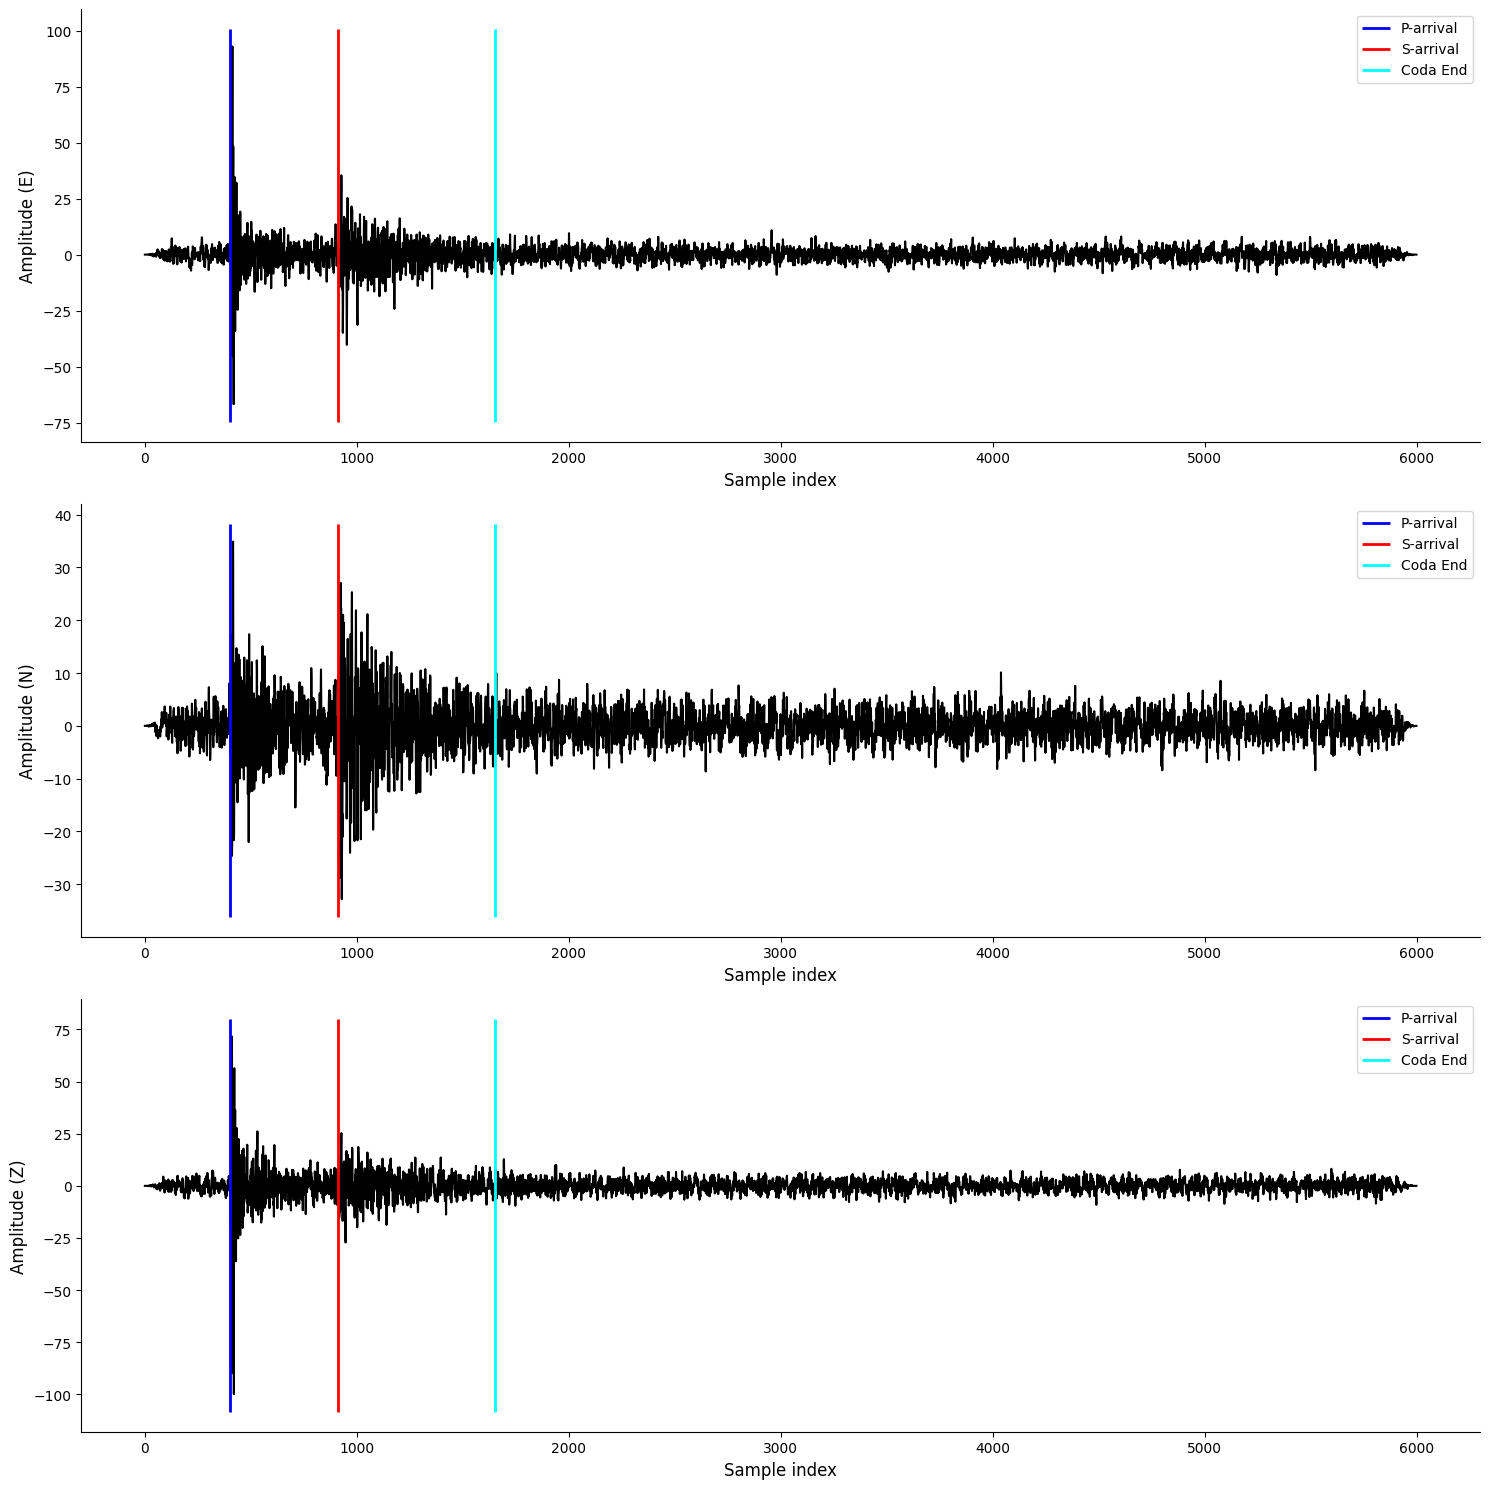

In [172]:
earthquakes[np.random.randint(0, len(earthquakes) - 1, 1)[0]].plot_waveforms()

/tmp/ipykernel_223381/4177545865.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize=10)


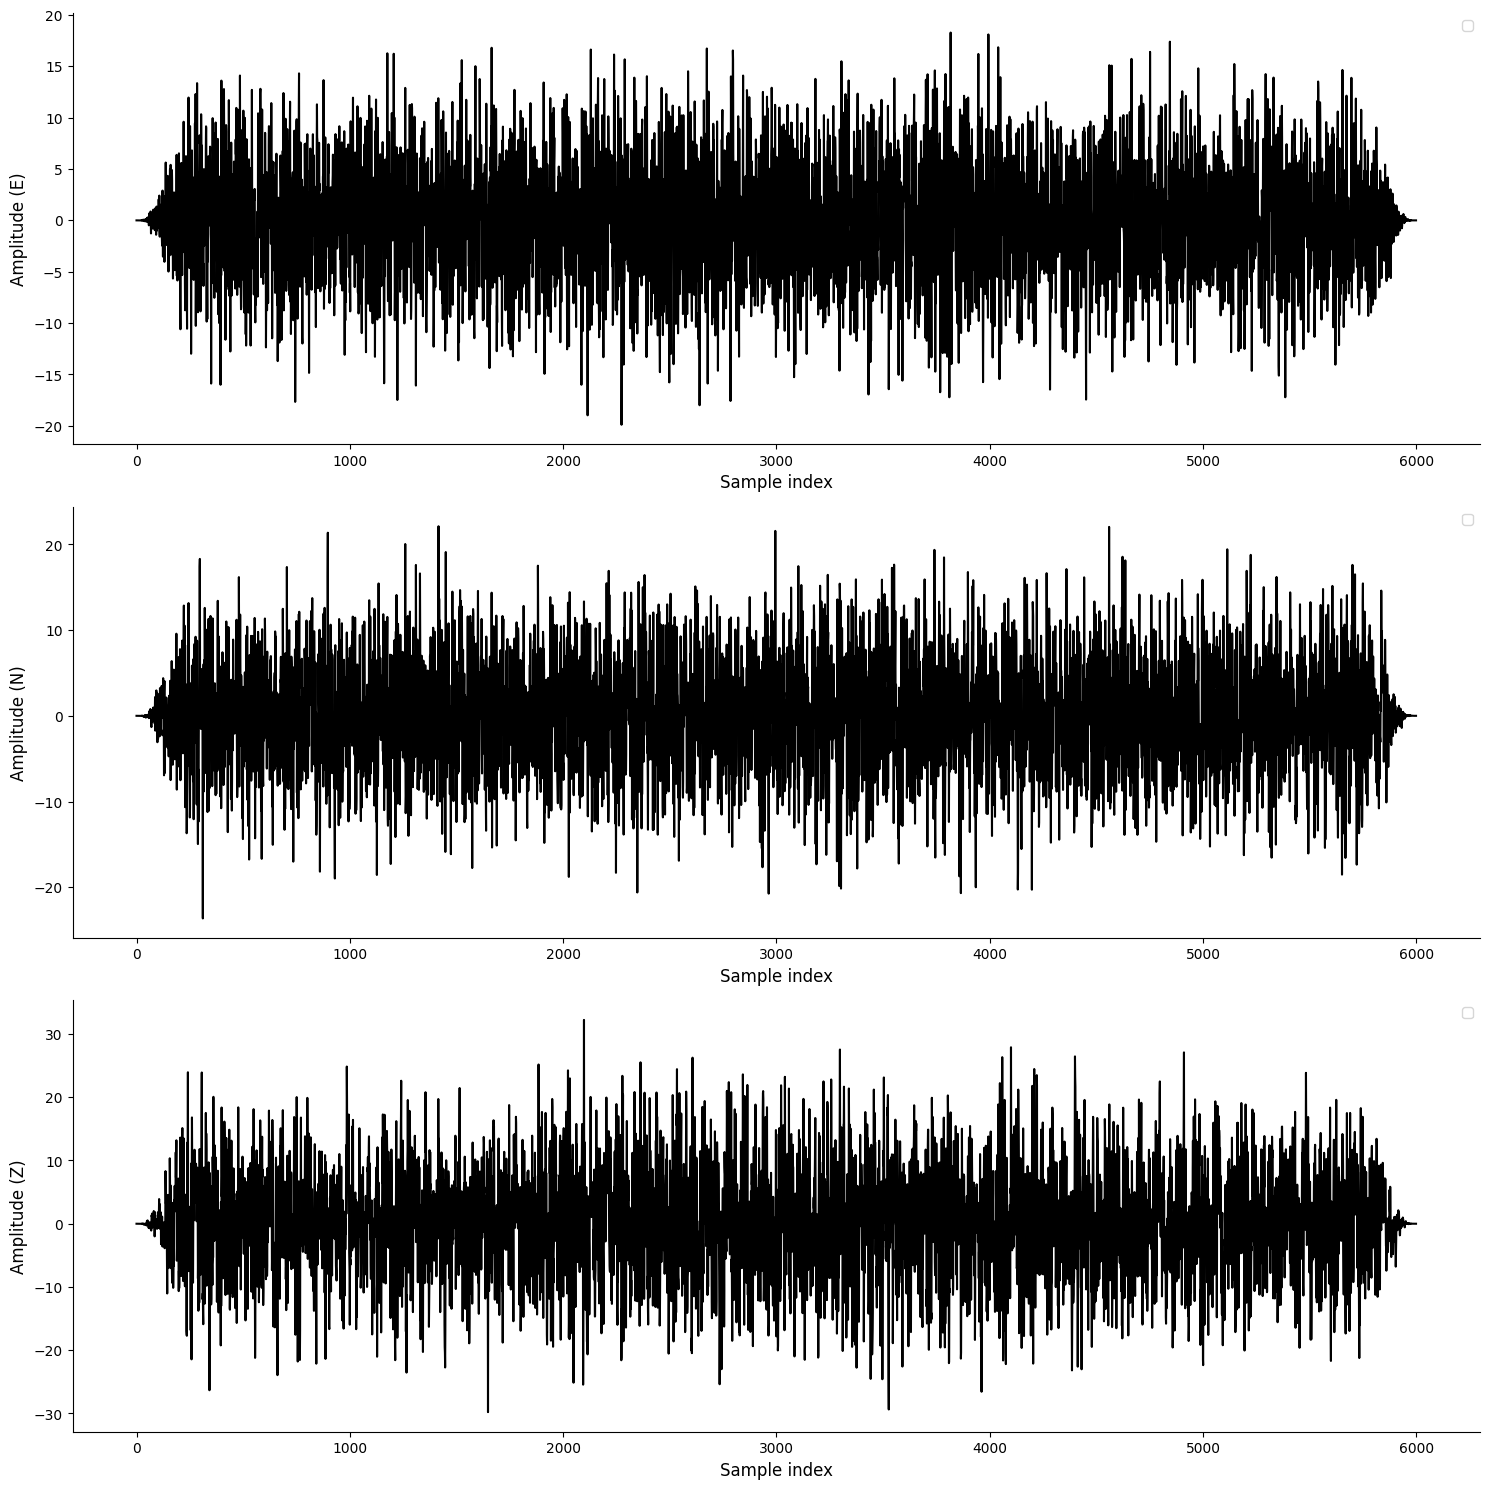

In [23]:
earthquakes_noise[10].plot_waveforms()


# Analyse des données

## Noise

In [24]:
def plot_mean_std(dataset, type_ = "Earthquake"):
    stds = []
    means = []
    for wave in dataset:
        mean = np.mean(wave.data, axis = 0)
        std = np.sqrt(np.mean((wave.data - mean) ** 2, axis = 0))
        stds.append(std)
        means.append(mean)

    means = np.array(means)
    stds = np.array(stds)
    fig, ax = plt.subplots(1, 2)
    fig.suptitle("Frequencies of mean and std along the three axis for " + type_)
    #ax[0].title("Frequencies of mean along the three axis for noise")
    ax[0].hist(means[:, 0], color = "blue", label = "East-west")
    ax[0].hist(means[:, 1], color ="red", label = "North-south" )
    ax[0].hist(means[:, 2], color = "green", label = "Vertical")
    ax[0].set_title("Frequencies of mean")
    ax[1].set_title("Frequencies of std")
    fig.legend()
    
    #ax[1].title("Frequencies of stds along the three axis for noise")
    ax[1].hist(stds[:, 0], color = "blue", label = "East-west")
    ax[1].hist(stds[:, 1], color ="red", label = "North-south" )
    ax[1].hist(stds[:, 2], color = "green", label = "Vertical")
    
    fig.savefig("Freq_" + type_)
    plt.show()
    return means, stds

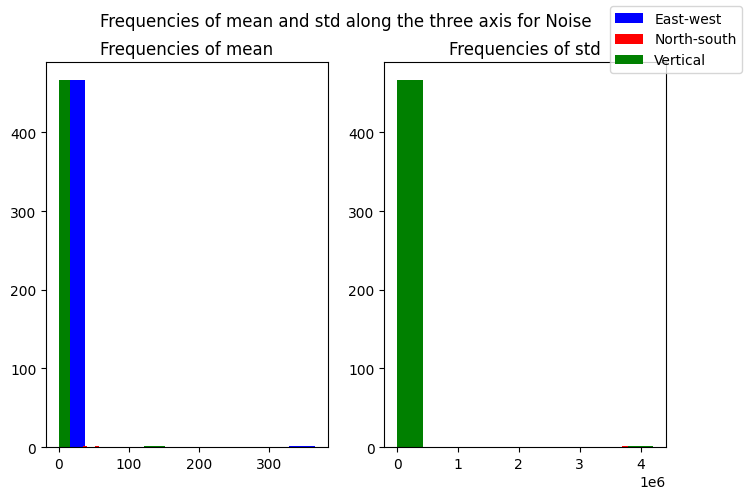

In [25]:
means, stds = plot_mean_std(earthquakes_noise, type_ = "Noise")

On remarque qu'il y'a quelques exemples de bruit qui ont une variance anormale.

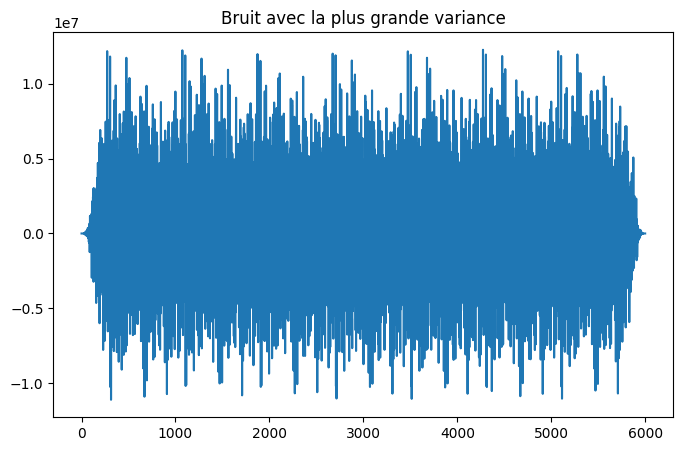

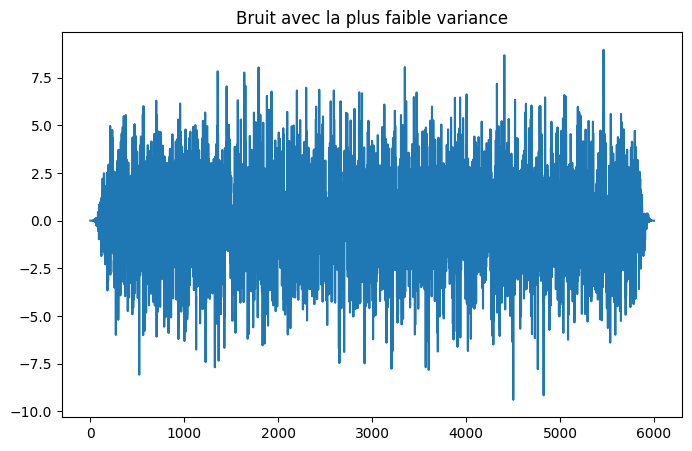

In [26]:
plt.title("Bruit avec la plus grande variance")
plt.plot(earthquakes_noise[np.argmax(stds, axis = 0)[1]].data[:, 1])
plt.show()
plt.title("Bruit avec la plus faible variance")
plt.plot(earthquakes_noise[np.argmin(stds, axis = 0)[1]].data[:, 1])
plt.show()

In [27]:
indices = np.unique(np.nonzero(stds > 3e6)[0])
print("Taille avant suppression : ", len(earthquakes_noise))
earthquakes_noise = np.delete(earthquakes_noise, indices)
print("Taille après suppression : ", len(earthquakes_noise))

Taille avant suppression :  468
Taille après suppression :  466


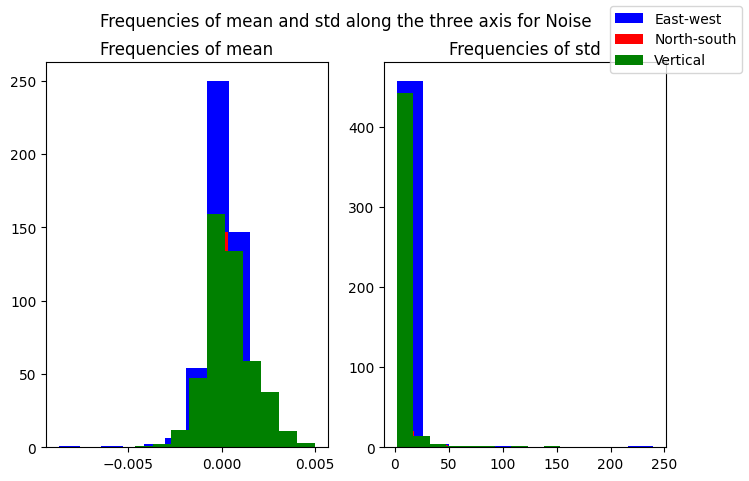

In [28]:
_ = plot_mean_std(earthquakes_noise, type_ = "Noise")

## Earthquake

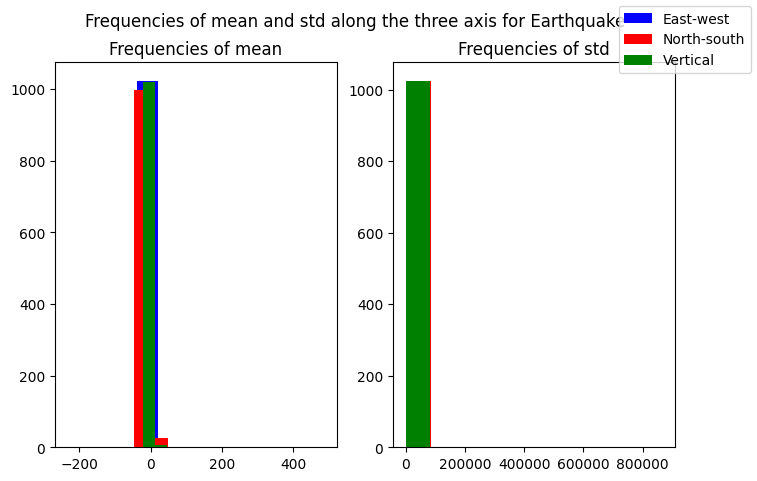

In [173]:
means, stds = plot_mean_std(earthquakes, type_ = "Earthquake")

Les moments d'ordre 1 et 2 sont sensiblement les mêmes entre les trois canaux.



In [176]:
earthquakes = np.array(earthquakes)
earthquakes_noise = np.array(earthquakes_noise)

In [189]:
random.seed(42)
test_prop = 0.1
test_size = int(len(earthquakes) * test_prop)
earthquakes_train, earthquakes_test = train_test_split(earthquakes, test_size = test_size)
print("Taille du jeu de train : ", len(earthquakes_train))
print("Taille du jeu de test : ", len(earthquakes_test))

Taille du jeu de train :  927
Taille du jeu de test :  103


In [190]:
# calcul de statistiques intéressantes.
powers = []
magnitudes = []
distances = []
coda = []
s_waves = []
p_waves = []
for wave in earthquakes_train:
    ffts = np.fft.fft(wave.data)
    power = np.abs(ffts) ** 2
    powers.append(power)
    magnitudes.append(wave.magnitude)
    distances.append(wave.distance)
    coda_end = wave.attrs["coda_end_sample"][0][0]
    coda.append((len(wave.data) - int(coda_end)) / FS) 
    s_waves.append((int(coda_end) - int(wave.attrs["s_arrival_sample"])) / FS) 
    p_waves.append((int(wave.attrs["s_arrival_sample"]) - int(wave.attrs["p_arrival_sample"])) / FS) 
powers = np.array(powers)

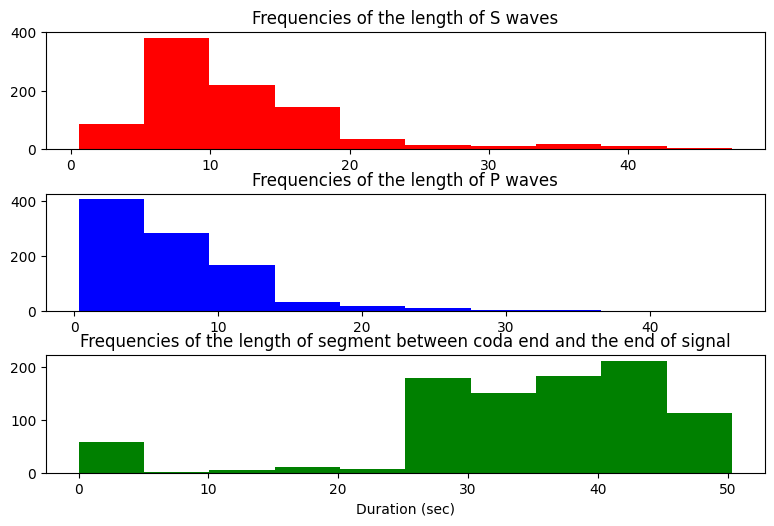

In [191]:
fig, ax = plt.subplots(3, 1)
fig.tight_layout()
ax[0].set_title("Frequencies of the length of S waves")
ax[1].set_title("Frequencies of the length of P waves")
ax[2].set_title("Frequencies of the length of segment between coda end and the end of signal")
ax[2].set_xlabel("Duration (sec)")
ax[0].hist(s_waves, color = "red")
ax[1].hist(p_waves, color = "blue")
ax[2].hist(coda, color = "green")
plt.savefig("Frequencies")
plt.show()

In [737]:
df = pd.DataFrame({"val" : p_waves})

In [742]:
print("Premier quartile et mediane")
df['val'].quantile([0.25, 0.5], interpolation='nearest')

Premier quartile et mediane


0.25    2.79
0.50    5.66
Name: val, dtype: float64

## Extraction de features

On va extraire nos features avec TsFresh.

In [192]:
def construction_data_frame(data, window_length = 1000, slide = 1):
    """
    Construit les dataframes de données compatible avec tsfresh.
    ---Args:
       data : Liste de signaux sismiques.
       window_length : Taille de la fenêtre.
       slide : Inverse du taux d'overlapping.
    ---Returns:
        DataFrame : le dataframe avec nos données, chaque exemple est divisé selon la taille de fenêtre et l'overlapping.
        labels : labels des fenêtres.
    """
    # Préparation des données pour tsfresh
    data_list = []
    features_res = []
    df_tsfresh = pd.DataFrame()
    index_total = 0
    targets = []
    labels = []
    for idx, eq in tqdm(enumerate(data)):
        # Extraction du canal Z (3e canal) de l'enregistrement
        vertical_channel = eq.data[:, 2] 
        pwave = int(eq.attrs["p_arrival_sample"])
        swave = int(eq.attrs["s_arrival_sample"])
        coda = int(eq.attrs['coda_end_sample'][0][0])
        targets = np.hstack(([1] * pwave, [2] * (swave - pwave), [3] * (coda - swave), [4] * (len(vertical_channel) - coda)))
        assert len(targets) == len(vertical_channel)
        # Construction du DataFrame pour tsfresh
        
        for j in range(0, len(vertical_channel), window_length // slide):
            portion = vertical_channel[j: (j + window_length)]
            labels_window = targets[j: (j + window_length)]
            unics, counts = np.unique(labels_window, return_counts = True)
            label = unics[np.argmax(counts)]
            
            labels.append(label)
            df = pd.DataFrame({
                'id': [index_total] * len(portion),  # ID unique pour chaque séisme
                'time': np.arange(len(portion)),  # Indices temporels
                'value': portion  # Valeurs du canal Z
            })
            data_list.append(df)
            index_total += 1
        
    return pd.concat(data_list, axis = 0), np.array(labels)

    


In [782]:
df_train, targets_train = construction_data_frame(earthquakes_train, window_length = 600)
df_test, targets_test = construction_data_frame(earthquakes_test, window_length = 600)

927it [00:02, 399.48it/s]
103it [00:00, 415.91it/s]


In [194]:
# On extrait les features
features_train =  extract_features(
        df_train, 
        column_id='id', 
        column_sort='time',
        default_fc_parameters=EfficientFCParameters(),
    n_jobs = 5
    )

Feature Extraction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [05:01<00:00, 12.07s/it]


In [195]:
features_test =  extract_features(
        df_test, 
        column_id='id', 
        column_sort='time',
        default_fc_parameters=EfficientFCParameters(),
    n_jobs = 5
    )

Feature Extraction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:35<00:00,  1.42s/it]


In [196]:
if "features_train" in locals():
    with open("Features_train", "wb") as f:
        pickle.dump(features_train, f)
        print("Fichier sauvegardé")
else:
    with open("Features_train", "rb") as f:
        features_train = pickle.load(f)
        print("Fichier chargé")

Fichier sauvegardé


In [197]:
if "features_test" in locals():
    with open("features_test", "wb") as f:
        pickle.dump(features_test, f)
        print("Fichier sauvegardé")
else:
    with open("features_test", "rb") as f:
        features_test = pickle.load(f)
        print("Fichier chargé")

Fichier sauvegardé


In [815]:
#with open("targets_train", "wb") as f:
#    pickle.dump( targets_train ,f)
#with open("targets_test", "wb") as f:
#    pickle.dump( targets_test ,f)

In [817]:
with open("targets_train", "rb") as f:
    targets_train = pickle.load(f)
with open("targets_test", "rb") as f:
    targets_test = pickle.load(f)

In [264]:
print("Nombre de features avant drop : ", len(features_train.columns))
features_train.dropna(inplace = True,axis=1)
features_test.dropna(inplace = True,axis=1)
print("Nombre de features après drop : ", len(features_train.columns))

Nombre de features avant drop :  776
Nombre de features après drop :  776


In [205]:
features = features_train
labels = (targets_train)

## Feature selection

In [630]:
from skrebate import ReliefF

relief = ReliefF(n_neighbors=10)  # j'ai mis a 10 neighbors
relief.fit(features_train.values, targets_train)

# Scores des features
relief_scores = relief.feature_importances_

ModuleNotFoundError: No module named 'skrebate'

In [ ]:
# On regarde l'histogramme
plt.hist(relief_scores, bins=200, color='blue', edgecolor='black')
plt.title('Histogramme des scores de ReliefF')
plt.xlabel('Scores de ReliefF')
plt.ylabel('Fréquence')
plt.show()

In [ ]:
# Trier les scores dans l'ordre décroissant
sorted_indices = np.argsort(relief_scores)[::-1]

# Conserver les X % des features les plus pertinentes
top_k_percentage = 0.6 
top_k = int(len(relief_scores) * top_k_percentage)

# Sélection des meilleures features
top_features_indices = sorted_indices[:top_k]
selected_features = features_train.iloc[:, top_features_indices]

print(f"Nombre de features sélectionnées maintenant : {selected_features.shape[1]}")

In [ ]:
# Trier les scores dans l'ordre décroissant
sorted_indices = np.argsort(relief_scores)[::-1]

# Conserver les 10 % des features les plus pertinentes
top_k_percentage = 0.7  # Exemple : conserver 70 % des meilleures features
top_k = int(len(relief_scores) * top_k_percentage)

# Sélection des indices des meilleures features
top_features_indices = sorted_indices[:top_k]

# Extraire les 50 meilleures features
top_50_features_indices = sorted_indices[:50]  # Garder uniquement les 50 premières
top_50_features_names = features_train.columns[top_50_features_indices]
top_50_features_scores = relief_scores[top_50_features_indices]

# Afficher les 50 meilleures features avec leurs scores
for feature, score in zip(top_50_features_names, top_50_features_scores):
    print(f"Feature: {feature}, Score: {score}")

In [208]:

#impute(extracted_features)
features_filtered = select_features(features, labels)

In [496]:
features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,0.0,-69.685822,8.204269e+05,12.072911,-0.092881,0.022194,-0.504380,...,0.320022,0.405902,0.520787,1.055041,1.191696,1.704096,2.245573,2.801479,3.368448,110.854507
1,1.0,0.0,0.0,0.0,-2129.689697,1.592055e+08,107.333954,-1.160722,0.139313,0.014539,...,0.247940,0.280179,0.431452,0.900026,1.215242,1.754734,2.295684,2.837573,3.394564,2381.500488
2,1.0,0.0,0.0,0.0,61.826416,2.959876e+08,222.907532,1.369637,-0.153733,37.066521,...,0.183378,0.391100,0.583795,0.991544,1.206768,1.725381,2.247243,2.785235,3.329665,1975.405151
3,1.0,0.0,0.0,0.0,2619.010254,3.008159e+08,223.777252,-2.145379,0.164656,-21.991383,...,0.125256,0.245901,0.475327,1.050448,1.195764,1.686307,2.180239,2.699715,3.232229,2063.543213
4,1.0,0.0,0.0,0.0,-5914.669922,1.643946e+09,464.096405,-0.983694,0.054900,-49.195747,...,0.320022,0.507123,0.681102,1.072511,1.251688,1.825287,2.407502,3.002234,3.562931,6342.519043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9265,1.0,0.0,0.0,0.0,794.739380,1.060478e+06,14.058167,-0.025454,-0.026537,1.979897,...,0.361788,0.660469,0.939387,1.628083,1.314712,1.988664,2.645386,3.321107,4.012043,119.476570
9266,1.0,0.0,0.0,0.0,-2431.787598,5.396544e+05,8.693249,-0.000069,-0.010314,-3.578723,...,0.478031,0.684954,0.934871,1.742431,1.327960,2.007887,2.690582,3.380682,4.083027,72.252914
9267,1.0,0.0,0.0,0.0,4386.737793,5.234077e+05,5.646996,0.080247,0.006949,5.553517,...,0.155665,0.170467,0.357079,1.252800,1.347258,2.027644,2.752129,3.526185,4.286283,88.031082
9268,1.0,0.0,0.0,0.0,-1536.200684,4.896493e+05,3.943000,-0.059438,-0.001137,0.155908,...,0.125256,0.125256,0.125256,0.755015,1.294550,1.962111,2.667342,3.376565,4.070925,80.057861


In [265]:
features_test_filtered = features_test[features_selected]

## Apprentissage de dictionnaires

In [406]:
from sklearn.decomposition import DictionaryLearning, MiniBatchDictionaryLearning
from sklearn.linear_model import OrthogonalMatchingPursuit
import numpy as np

def dictionary_learning(list_features, n_atoms = 50,n_nonzero_coefs = 10, alpha = 1):
    """
    Apprentissage d'un dictionnaire à partir des features pour un label donné.
    ---Args:
        list_features : liste d'exemples.
        n_atoms : Nombre d'atomes dans le dictionnaire.
        n_nonzero_coefs : Taux de parcimonie (Nombre de coefficients non nuls).
    """
    X = list_features
    dict_learner = DictionaryLearning(
    n_components=n_atoms,  # Nombre d'atomes
    fit_algorithm='lars',  # Algorithme OMP pour apprentissage
    transform_algorithm='omp',  # Utiliser OMP pour représenter les signaux
    transform_n_nonzero_coefs=n_nonzero_coefs,  # Nombre de coefficients non
    random_state=10,  # Pour reproductibilité,
    n_jobs = -1,
    alpha = alpha,
    tol = 1e-3
    )

    dictionary = dict_learner.fit(X).components_

    sparse_codes = dict_learner.transform(X)
    
    return dictionary, sparse_codes

In [410]:
def dictionary_per_label(features, labels, n_comps = None, n_nonzeros = None, alphas = None, verbose = False):
    """
    Construit un dictionnaire par type de label.
    ---Args:
        Features : données, contient les features extraites pour chaque exemple.
        labels : labels des fenêtres.
        n_comps : Liste de nombre d'atomes pour chaque label.
        n_nonzeros : Liste de nombre de coefficients non nuls.
    ---Returns:
        dictionnaries : dictionnaire pour chaque type de labels.
        sparses : Représentation sparse pour chaque dictionnaire.
    """
    N_COMP_BASE = 50
    N_NONZERO_BASE = 10
    ALPHA_BASE = 1
    labels_unics = np.unique(labels)
    dicts = []
    sparses = []
    if isinstance(features, pd.DataFrame):
        features = features.to_numpy()
    if n_comps is None or len(n_comps) != len(labels_unics):
        n_comps = [N_COMP_BASE] * len(labels_unics)
    if n_nonzeros is None or len(n_nonzeros) != len(labels_unics):
        n_nonzeros = [N_NONZERO_BASE] * len(labels_unics)
    if alphas is None or len(alphas) != len(labels_unics):
        alphas = [ALPHA_BASE] * len(labels_unics)
    features = np.array(features)
    for label, n_comp, n_nonzero, alpha in tqdm(zip(labels_unics, n_comps, n_nonzeros, alphas)):
        if verbose:
            print("---------------------------------------------------------------------------------------------------------------------")
            print(f"Learning dictionary for label {label} with hyperparameters n_comp({n_comp}), n_nonzero({n_nonzero}), alpha({alpha})")
        features_label = features[np.where(labels == label)]
        dict_, sparse = dictionary_learning(features_label, n_comp,n_nonzero, alpha)
        dicts.append(dict_)
        sparses.append(sparse)
        
    return dicts, sparses

In [411]:
# Normalisation Z des features.
features_scaled = features_filtered.copy() 

for column in features_filtered.columns: 
    features_scaled[column] = (features_filtered[column] - np.mean(features_filtered[column]))   /np.std(features_filtered[column])


In [412]:
#dict_noise, sparse_noise = dictionary_learning(X_train_noise, 50,30)
dicts, sparses = dictionary_per_label(features_scaled, labels, [70, 150, 150, 100], verbose = True)

0it [00:00, ?it/s]

---------------------------------------------------------------------------------------------------------------------
Learning dictionary for label 1 with hyperparameters n_comp(70), n_nonzero(10), alpha(1)


1it [00:05,  5.98s/it]

---------------------------------------------------------------------------------------------------------------------
Learning dictionary for label 2 with hyperparameters n_comp(150), n_nonzero(10), alpha(1)


2it [00:13,  6.81s/it]

---------------------------------------------------------------------------------------------------------------------
Learning dictionary for label 3 with hyperparameters n_comp(150), n_nonzero(10), alpha(1)


3it [00:34, 13.55s/it]

---------------------------------------------------------------------------------------------------------------------
Learning dictionary for label 4 with hyperparameters n_comp(100), n_nonzero(10), alpha(1)


4it [01:01, 15.45s/it]


In [413]:
from sklearn.linear_model import OrthogonalMatchingPursuit

def represent_signal(signal, dictionary, n_nonzero_coefs):
    """
    Application de OMP pour avoir une représentation sparse d'un signal à partir d'un dictionnaire
    ---Args:
        signal : un signal de features.
        dictionary : dictionnaire calculé à l'étape d'avant.
        n_nonzero_coefs : sparcité de l'approximation.
    ---Returns:
        reconstruction : Reconstruction du signal.
        residu : Residu entre le signal reconstruit et le signal réel.
    """
    
    # Ajustement OMP pour représenter le signal
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
    
    omp.fit(dictionary.T, signal)
    sparse_code = omp.coef_
    
    # Reconstruction et calcul du résidu
    reconstruction = dictionary.T @ sparse_code
    residu = np.linalg.norm(signal - reconstruction)
    
    return reconstruction, residu

## Tests

### Score sur jeu de train

On s'assure que le modèle apprend sur les données de train, et on pourra également juger du taux d'overfit.

In [431]:
def score(features, labels):
    acc = 0 # Accuracy
    if isinstance(features, pd.DataFrame):
        features = features.to_numpy()
    print(len(labels))
    pbar = tqdm(zip(features, labels))
    labels_unique , n_labels = np.unique(labels, return_counts = True)
    labels_acc = [0] * len(labels_unique) # Accuracy par vrai label.
    predictions = {} # predictions pour chaque vrai label
    for k in labels_unique:
        predictions[k] = []
    for feature, label in pbar:
        residuals = []        
        for dict_, sparse in zip(dicts, sparses):
            res = represent_signal(feature, dict_, 10)[1]
            residuals.append(res)
        label_predicted = np.argmin(residuals) + 1 # Residu minimum
        
        #n += 1
        acc += (label == label_predicted)
        labels_acc[int(label) - 1] += (label == label_predicted)
        predictions[label].append(label_predicted)
        pbar.set_description(f"Accuracy ({acc:3f})")
    labels_acc = np.array(labels_acc) / n_labels
    acc = acc / len(labels)
    return acc, labels_acc, predictions 

In [432]:
acc, labels_accs, predictions = score(features_scaled, labels)

9270


Accuracy (7207.000000): : 9270it [00:59, 154.83it/s]


Dans l'ordre : Pre_seisme - Onde_P - Onde_S - Post_seisme
Accuracy par label sur jeu de test :  [0.75       0.57758621 0.39631336 0.82788296]
Accuracy globable :  0.7


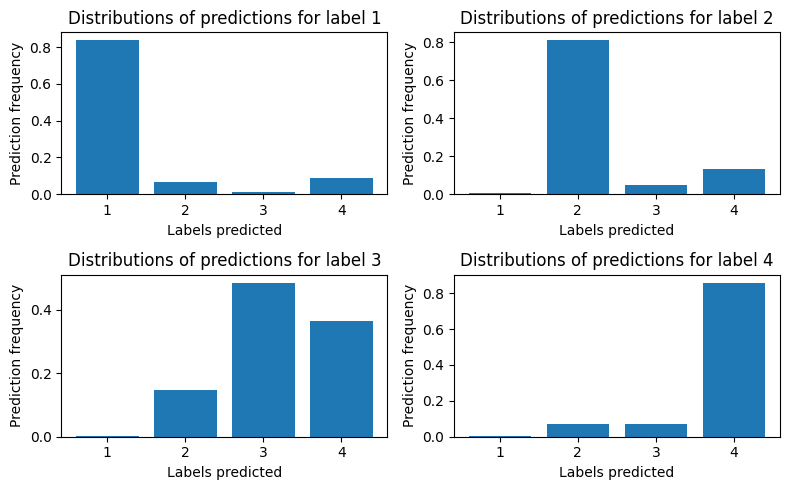

In [433]:
print("Dans l'ordre : Pre_seisme - Onde_P - Onde_S - Post_seisme")
print("Accuracy par label sur jeu de test : ", labels_acc_test)
print("Accuracy globable : ", acc_test)
labels_uniques, n_labels= np.unique(labels, return_counts = True)
fig, ax = plt.subplots(2, 2)
for label in labels_uniques:
    i, j = (label - 1) //2, (label - 1)  %2
    ax[i][j].set_title(f"Distributions of predictions for label {label}")
    bins, heights = np.unique(predictions[label], return_counts = True)
    heights = heights / sum(heights)

    ax[i][j].set_xlabel("Labels predicted")
    ax[i][j].set_ylabel("Prediction frequency")
    ax[i][j].bar(bins, heights, align = "center",)
fig.tight_layout()
plt.savefig("Distribution_preds_train")
plt.show()

Les fins de signaux sismiques sont bien prédits.
Le modèle a tendance à confondre les ondes S avec les ondes post sismiques.

Coda a beaucoup plus de données.
Ne pas overfit = mettre moins d'atomes.

### Score sur jeu de test

In [266]:
features_test_scaled = features_test_filtered.copy()

for column in features_filtered.columns: 
    features_test_scaled[column] = (features_test_filtered[column] - np.mean(features_test_filtered[column]))   /np.std(features_test_filtered[column])


In [365]:
acc_test, labels_acc_test, predictions_test = score(features_test_scaled, targets_test)

Accuracy (721.000000): : 1030it [00:06, 156.38it/s]


Dans l'ordre : Pre_seisme - Onde_P - Onde_S - Post_seisme
Accuracy par label sur jeu de test :  [0.75       0.57758621 0.39631336 0.82788296]
Accuracy globable :  0.7


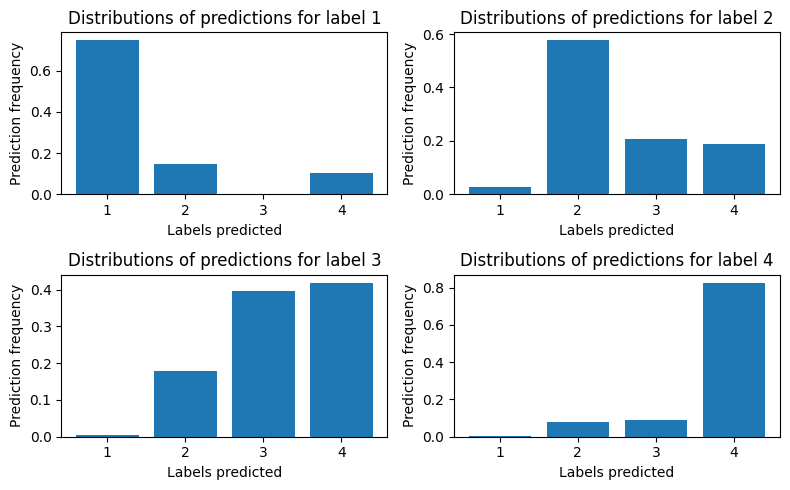

In [376]:
print("Dans l'ordre : Pre_seisme - Onde_P - Onde_S - Post_seisme")
print("Accuracy par label sur jeu de test : ", labels_acc_test)
print("Accuracy globable : ", acc_test)
labels_uniques, n_labels= np.unique(targets_test, return_counts = True)
fig, ax = plt.subplots(2, 2)
for label in labels_uniques:
    i, j = (label - 1) //2, (label - 1)  %2
    ax[i][j].set_title(f"Distributions of predictions for label {label}")
    bins, heights = np.unique(predictions_test[label], return_counts = True)
    heights = heights / sum(heights)
    #bins = np.insert(bins, label - 1, label )
    #heights = np.insert(heights, label - 1,0) / n_labels
    ax[i][j].set_xlabel("Labels predicted")
    ax[i][j].set_ylabel("Prediction frequency")
    ax[i][j].bar(bins, heights, align = "center",)
plt.savefig("Distribution_preds_test")

fig.tight_layout()
plt.show()

In [377]:
print(f"Perte en accuracy du jeu de train vers le jeu de test : {labels_acc - labels_acc_test}")

Perte en accuracy du jeu de train vers le jeu de test : [ 0.18474265  0.21150844  0.23202451 -0.23755738]


Au vu des histogrammes, on voit que les prédictions pour les labels 1 et 4 sont sensiblement les mêmes.
Cependant, la précision pour le label 3 s'est beaucoup dégradé, et on constate également une dégradation moindre pour le label 2, indiquant un overfit.

Le modèle a gagné en accuracy pour le dernier label. Cela vient probablement du fait qu'il se repose trop sur ces connaissances de la classe 4 (qui est beaucoup plus présente que les autres classes), et qu'il a tendance à prédire la classe 4 lorsqu'il a un doute pour un exemple qui est de classe 3 ou 4.

## Mise en place du modèle et cross validation

In [596]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    
    def fit(self, X, y):
        """
        ---Args:
            X : DataFrame containing the raw features
            y : labels
        """
        features_filtered = select_features(X, y)
        self.features_names = features_filtered.columns
        self.features_indices = np.where(np.isin(X.columns, self.features_names ))[0]
        return self  # Always return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        X = np.array(X)
        return X[:, self.features_indices]

In [612]:

class DicLearning_Signal(BaseEstimator, ClassifierMixin):
    """
    Class for dictionary learning on features.
    """
    def __init__(self, n_comps = None, n_nonzeros_coefs = None, alphas = None):
        """
            ---Args:
                n_comps : Liste de nombre d'atomes pour chaque label.
                n_nonzeros : Liste de nombre de coefficients non nuls.
                alphas : Liste de coefficients de parcimonie.
        """
        self.n_comps = n_comps 
        self.n_nonzeros_coefs = n_nonzeros_coefs
        self.alphas = alphas 
    def fit(self, X, y, verbose = False):
        """
        ---Args:
            X : données, contient les features extraites pour chaque fenêtre.
            labels : labels des fenêtres.
        """
        self.dicts, self.sparses = dictionary_per_label(X, y, self.n_comps, self.n_nonzeros_coefs, self.alphas, verbose = verbose)
        return self 
    
    def predict(self, X, n_nonzero_coef = 10, verbose = False):
        labels_predicted = []
        if isinstance(X, pd.DataFrame):
                X = X.to_numpy()
        iterable = X
        if verbose:
            iterable = tqdm(X)
        for feature in iterable:
            
            residuals = []        
            for dict_, sparse in zip(self.dicts, self.sparses):
                res = represent_signal(feature, dict_, n_nonzero_coef)[1]
                residuals.append(res)
            labels_predicted.append(np.argmin(residuals) + 1) # Residu minimum
            
        return np.array(labels_predicted)

    def score(self, X, y, n_nonzero_coef = 10, verbose = False):
        predictions = self.predict(X, verbose = verbose)
        return np.sum(predictions == y) / len(y)

In [484]:
acc = model.score(features_scaled, labels, verbose = True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9270/9270 [00:34<00:00, 267.69it/s]


In [485]:
print(f"Accuracy sur le jeu de train : {acc:2f}")

Accuracy sur le jeu de train : 0.748975


In [613]:
pipe = Pipeline([("selector", FeatureSelector()), ("scaler", StandardScaler()), ("dico", DicLearning_Signal())])

In [635]:
pipe.fit(features_train, labels)

4it [00:51, 12.98s/it]


Pipeline(steps=[('selector', FeatureSelector()), ('scaler', StandardScaler()),
                ('dico', DicLearning_Signal(n_comps=[50, 100, 100, 50]))])

In [636]:
pipe.score(features_test, targets_test, verbose = True)

0.6009708737864078

In [700]:
params ={"dico__n_comps" : [[100, 150, 200, 100],
                            [100, 100, 100, 100],
                            [100, 150, 150, 100],
                             [100, 100, 150, 100]],
         "dico__n_nonzeros_coefs" : [[50, 60, 60, 50],
                                     [30, 30, 30, 30],
                                     [10, 20, 20, 10],
                                     [10, 10, 10, 10]],
         
         "dico__alphas" : [[1, 1, 1, 1],
                           [1, 1, 1, 1],
                           [1, 1, 1, 2],
                           [1, 1, 1, 1]]
    }
all_scores = []
labels_uniq = np.unique(val_labels)
for i in tqdm(range(len(params["dico__n_comps"]))):
    strat_k_fold = StratifiedKFold(n_splits=3, shuffle=True)
    clf = Pipeline([("selector", FeatureSelector()), ("scaler", StandardScaler()), ("dico", DicLearning_Signal())])
    dico__n_comps = params["dico__n_comps"][i]
    dico__n_nonzeros_coefs =params["dico__n_nonzeros_coefs"][i]
    dico__alphas = params["dico__alphas"][i]
    clf.set_params(dico__n_comps = dico__n_comps, dico__n_nonzeros_coefs = dico__n_nonzeros_coefs, dico__alphas = dico__alphas)
    accuracy_fold = []
    accuracy_per_label_fold = []
    for i, (train_index, test_index) in enumerate(strat_k_fold.split(features_train, labels)):
        train_data = features_train.iloc[train_index]
        val_data = features_train.iloc[test_index]
        train_labels = labels[train_index]
        val_labels = labels[test_index]
        clf.fit(train_data, train_labels)
        pred_labels = clf.predict(val_data)
        accuracy_fold.append(np.sum(pred_labels == val_labels) / len(val_labels))
        accuracy_per_label = []
        for label in labels_uniq:
            indices = np.where(val_labels == label)[0]
            val_labels_for_label = val_labels[indices]
            pred_labels_for_label = pred_labels[indices]
            accuracy_per_label.append(np.sum(pred_labels_for_label == val_labels_for_label) / len(val_labels_for_label)   )
        accuracy_per_label_fold.append(accuracy_per_label)
    all_scores.append((accuracy_fold, accuracy_per_label_fold))

  0%|                                                                                                                                                                                                                  | 0/4 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:05,  5.97s/it]/home/danube/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:186: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)

2it [00:11,  5.76s/it]
3it [00:28, 10.66s/it]
4it [00:48, 12.06s/it]

0it [00:00, ?it/s]
1it [00:05,  5.34s/it]/home/danube/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:186: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)
/home/danube/.local/lib/python3.10/site-packages/sklearn/ut

In [769]:
for score, score_label in all_scores:
    print(f"Score : {np.mean(score)} (mean) | {np.std(score)} (std)")
    scores_label_mean = np.zeros(4)
    for i in range(3):
        scores_label_mean = np.vstack((scores_label_mean, score_label))
    scores_label_std = np.std(scores_label_mean, axis = 0)
    scores_label_mean = np.mean(scores_label_mean, axis = 0)
    for label in [1, 2, 3, 4]:
        print(f"    Score for label {label}: {np.mean(scores_label_mean[label - 1])} (mean) | {np.std(scores_label_std[label - 1])} (std)")

Score : 0.6823085221143473 (mean) | 0.004758736785353385 (std)
    Score for label 1: 0.7097484133144606 (mean) | 0.0 (std)
    Score for label 2: 0.45925925925925926 (mean) | 0.0 (std)
    Score for label 3: 0.48209219858156027 (mean) | 0.0 (std)
    Score for label 4: 0.667755817779373 (mean) | 0.0 (std)
Score : 0.7368932038834952 (mean) | 0.0032145985816076383 (std)
    Score for label 1: 0.7428336605634447 (mean) | 0.0 (std)
    Score for label 2: 0.44351851851851853 (mean) | 0.0 (std)
    Score for label 3: 0.2884262379256121 (mean) | 0.0 (std)
    Score for label 4: 0.8147733645908112 (mean) | 0.0 (std)
Score : 0.5392664509169364 (mean) | 0.040051367586652134 (std)
    Score for label 1: 0.747792338249395 (mean) | 0.0 (std)
    Score for label 2: 0.5555555555555556 (mean) | 0.0 (std)
    Score for label 3: 0.5993453355155482 (mean) | 0.0 (std)
    Score for label 4: 0.38060148211294564 (mean) | 0.0 (std)
Score : 0.7209277238403452 (mean) | 0.0028500204560135997 (std)
    Score fo

In [784]:
pipe = Pipeline([("selector", FeatureSelector()), ("scaler", StandardScaler()), ("dico", DicLearning_Signal())])
pipe.set_params(dico__n_comps = [100, 150, 150, 100], dico__n_nonzeros_coefs = [10, 20, 20, 10], dico__alphas = [1, 1, 1, 2])

Pipeline(steps=[('selector', FeatureSelector()), ('scaler', StandardScaler()),
                ('dico',
                 DicLearning_Signal(alphas=[1, 1, 1, 2],
                                    n_comps=[100, 150, 150, 100],
                                    n_nonzeros_coefs=[10, 20, 20, 10]))])

In [785]:
pipe.fit(features_train, targets_train)

4it [00:49, 12.36s/it]


Pipeline(steps=[('selector', FeatureSelector()), ('scaler', StandardScaler()),
                ('dico',
                 DicLearning_Signal(alphas=[1, 1, 1, 2],
                                    n_comps=[100, 150, 150, 100],
                                    n_nonzeros_coefs=[10, 20, 20, 10]))])

### Exemple

In [807]:
predictions_examples = pipe.predict(features_test.iloc[20:30])

In [808]:
predictions_examples

array([1, 2, 2, 3, 2, 3, 3, 2, 3, 4])

In [809]:
targets_test[20:30]

array([1, 2, 2, 2, 3, 3, 4, 4, 4, 4])

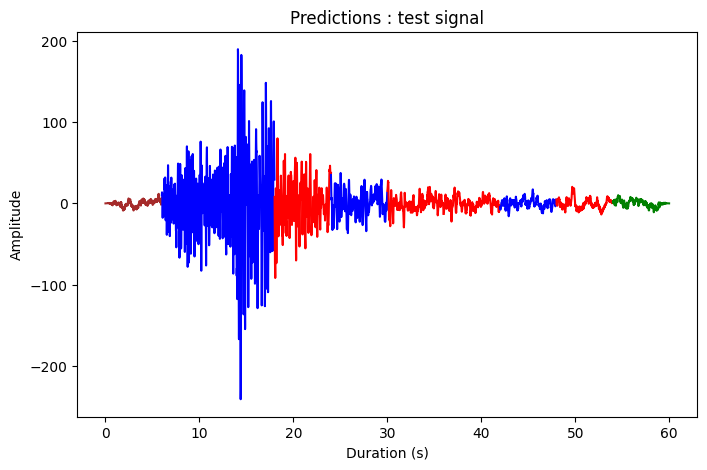

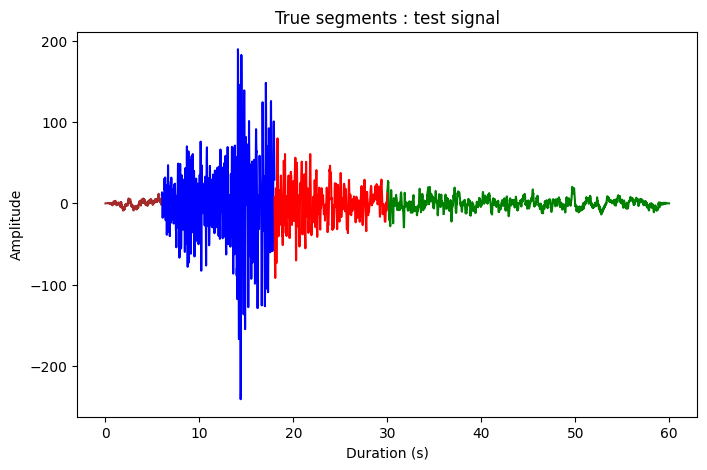

In [818]:
plt.title("Predictions : test signal")
plt.xlabel("Duration (s)")
plt.ylabel("Amplitude")
colors = {1 : "brown", 2: "blue", 3: "red", 4 :"green"}
window_size = 600
for i, label in enumerate(predictions_examples):
    start = i * window_size
    end = start + window_size
    
    plt.plot(np.arange(start, end) / 100, earthquakes_test[3].data[:, 2][start:end], color = colors[label])
plt.savefig("prediction_signal")
plt.show()
plt.title("True segments : test signal")
plt.xlabel("Duration (s)")
plt.ylabel("Amplitude")
for i, label in enumerate(targets_test[20:30]):
    start = i * window_size
    end = start + window_size
    
    plt.plot(np.arange(start, end) / 100, earthquakes_test[3].data[:, 2][start:end], color = colors[label])
plt.savefig("real_signal")

In [ ]:
plt.title("True segments : test signal")
plt.xlabel("Duration (s)")
plt.ylabel("Amplitude")
for i, label in enumerate(targets_test[20:30]):
    start = i * window_size
    end = start + window_size
    
    plt.plot(np.arange(start, end) / 100, earthquakes_test[3].data[:, 2][start:end], color = colors[label])
plt.savefig("real_signal")

## Taille de fenêtre réduite.
On utilise une taille de fenêtre inférieure (250).

In [719]:
df_train, targets_train = construction_data_frame(earthquakes_train, window_length = 250)
df_test, targets_test = construction_data_frame(earthquakes_test, window_length = 250)

927it [00:02, 407.52it/s]
103it [00:00, 404.28it/s]


In [705]:
features_train =  extract_features(
        df_train, 
        column_id='id', 
        column_sort='time',
        default_fc_parameters=EfficientFCParameters(),
    n_jobs = 5
    )
features_test =  extract_features(
        df_test, 
        column_id='id', 
        column_sort='time',
        default_fc_parameters=EfficientFCParameters(),
    n_jobs = 5
    )

Feature Extraction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:12<00:00,  2.90s/it]


In [723]:
with open("Features250train", "rb") as f:
    features_train = pickle.load(f)
with open("Features250test", "rb") as f:
    features_test = pickle.load(f)    

In [727]:
features_train.dropna(inplace = True, axis = 1)
features_test.dropna(inplace = True, axis = 1)

In [728]:
pipe500 = Pipeline([("selector", FeatureSelector()), ("scaler", StandardScaler()), ("dico", DicLearning_Signal())])
pipe500.fit(features_train, targets_train)

4it [02:39, 39.94s/it]


Pipeline(steps=[('selector', FeatureSelector()), ('scaler', StandardScaler()),
                ('dico', DicLearning_Signal())])

In [731]:
score500 = pipe500.score(features_test, targets_test)

In [743]:
predictions500 = pipe500.predict(features_test)

In [753]:
score500

0.5651294498381877

In [748]:
accuracy_per_label = []
for label in labels_uniq:
    indices = np.where(targets_test == label)[0]
    targets_labels_for_label = targets_test[indices]
    pred_labels_for_label = predictions500[indices]
    accuracy_per_label.append(np.sum(pred_labels_for_label == targets_labels_for_label) / len(targets_labels_for_label)   )

In [774]:
print("Accuracy per label : ", accuracy_per_label)
print("Score : ", score500)

Accuracy per label :  [0.6167883211678832, 0.5368421052631579, 0.14204545454545456, 0.7220216606498195]
Score :  0.5651294498381877


## Custom implementation

In [130]:
def Projected_gradient_descent(signal,sparse_activation_matrix, max_iter=1000, alpha=0.01):
    
    # Initialisation du dictionnaire avec des colonnes normalisées
    dictionary = np.random.randn(signal.shape[0], sparse_activation_matrix.shape[0])
    dictionary = dictionary / np.linalg.norm(dictionary, axis=0)

    n_iter = 0

    while n_iter < max_iter:
        gradient = (dictionary @ sparse_activation_matrix - signal) @ sparse_activation_matrix.T
        dictionary = dictionary - alpha * gradient

        # Normalisation des colonnes du dictionnaire
        norms = np.linalg.norm(dictionary, axis=0)
        dictionary /= np.maximum(norms, 1)
        n_iter += 1

    return(dictionary)

In [129]:

def OrthogonalMatchingPursuitMultiple(signals, dictionary, n_nonzero_coefs):
    # Dimensions
    N, M = signals.shape
    K = dictionary.shape[1]

    activation_matrix = np.zeros((K, M))  # Matrice d'activation

    for m in range(M):  # Traiter chaque signal individuellement
        signal = signals[:, m]
        residual = signal.copy()
        selected_atoms = []
        z = np.zeros(K)  # Vecteur d'activation pour le signal courant

        n_iter = 0
        max_iter = n_nonzero_coefs
        while n_iter < max_iter:
            # Calcul des projections
            inner_products = dictionary.T @ residual
            k_star = np.argmax(np.abs(inner_products))
            selected_atoms.append(k_star)

            # Résolution des moindres carrés sur les atomes sélectionnés
            D_selected = dictionary[:, selected_atoms]
            z_selected, _, _, _ = np.linalg.lstsq(D_selected, signal, rcond=None)

            # Mise à jour du résidu
            residual = signal - D_selected @ z_selected

            n_iter += 1

        # Mettre à jour le vecteur d'activation
        for i, k in enumerate(selected_atoms):
            z[k] = z_selected[i]

        activation_matrix[:, m] = z


    return activation_matrix

In [135]:
def alternated_resolution(signals, max_iter=100, alpha=0.01, n_nonzero_coefs=30):
    # Initialisation du dictionnaire avec des colonnes normalisées
    signals = signals.values
    dictionary = np.random.randn(signals.shape[0], n_nonzero_coefs)
    dictionary = dictionary / np.linalg.norm(dictionary, axis=0)

    n_iter = 0

    for i in tqdm(range(max_iter)):
        # Calcul des activations
        sparse_activation_matrix = OrthogonalMatchingPursuitMultiple(signals, dictionary, n_nonzero_coefs)

        # Mise à jour du dictionnaire
        dictionary = Projected_gradient_descent(signals, sparse_activation_matrix, max_iter=max_iter, alpha=alpha)

        n_iter += 1

    return dictionary, sparse_activation_matrix

In [126]:
X_train_eq.values

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.28373634e+00, 3.96485228e+00, 2.08385075e+06],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.56769579e+00, 5.59103481e+00, 2.21664594e+05],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.26515835e+00, 6.62333502e+00, 5.49761688e+05],
       ...,
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.87962162e+00, 7.32928432e+00, 2.57672453e+05],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.97182739e+00, 3.63991296e+00, 4.67113750e+05],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.60250044e+00, 4.45044249e+00, 2.38953550e+06]])

In [136]:
dict_noise_custom, sparse_noise_custom = alternated_resolution(X_train_noise, n_nonzero_coefs=30)
dict_eq_custom, sparse_eq_custom = alternated_resolution(X_train_eq, n_nonzero_coefs=30)

100%|██████████| 100/100 [10:49<00:00,  6.50s/it]
